# Bayesian Inference with Stan

### Bayesian Workflow

In general the Bayesian workflow consists of steps:

- Consider the social process that generates your data. The goal of your statistical model should be to model the data generating process, so think hard about this. Exploratory analysis goes a long way towards helping you to understand this process.
- Program your statistical model and sample from it.
- Evaluate your model’s reliability. Check for Markov chain convergence to make sure that your model has produced reliable estimates.
- Evaluate your model’s performance. How well does your model approximate the data generating process? This involves using posterior predictive checks.
- Summarize your model’s results in tabular and graphical form.

### Imports

In [33]:
import os
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from cmdstanpy import CmdStanModel

from matplotlib import style 
style.use('../../PlottingStyle.mplstyle')

%config InlineBackend.figure_formats = ['svg']

### Stan Syntax

Stan requires the coding of your model in different blocks and in a specific order. In order, these blocks are data, transformed data, parameters, transformed parameters, model, and generated quantities. Let’s suppose that we wanted to estimate the following equation with Stan:

$$
\begin{aligned}
y &\sim \text{Normal}(\mu, \sigma)\\
\mu &= \alpha + \beta x \\
\alpha &\sim \text{Normal}(0, 10)\\
\beta &\sim \text{Normal}(0, 10)\\
\sigma &\sim \text{Unifrom}(0, 100)\\
\end{aligned}
$$

A complete Stan program for this model looks like the following:

In [2]:
linear_reg_1 = '''
data {              // This is the data block
    int N;          // Specify Sample Size
    array[N] real y;      // A variable named y with length n
    array[N] real x;      // A variable named x with length n
}

transformed data {
  // this is where you could specify variable transformations
}

parameters {        // Block for parameters to be estimated
  real a;           // A parameter named a
  real b;           // A parameter named b
  real sigma;       // A parameter named sigma
}

transformed parameters {
  // Here you could specify transformations of your parameters
}

model {
  vector[N] mu;     // create the linear predictor mu

  // Write the linear model
  for (i in 1:N) {
    mu[i] = a + b * x[i];
  }

  // Write out priors
  a ~ normal(0, 10);
  b ~ normal(0, 10);
  sigma ~ uniform(0, 100);

  // Write out the likelihood function
  for (i in 1:N) {
  y[i] ~ normal(mu[i], sigma);
  }
}

generated quantities {
  // Here you can calculate things like log-likelihood, replication data, etc.
}
'''

In [3]:
stan_file = './stan_models/linear_reg_1'
if not os.path.isfile(stan_file):
    with open(stan_file+".stan", 'w') as f:
        print(linear_reg_1, file=f)
    stan_model = CmdStanModel(stan_file=stan_file+".stan", cpp_options={'STAN_THREADS':'true', 'parallel_chains': 4})
else:
    stan_model = CmdStanModel(exe_file=stan_file)

After programming the model, you run the code which will tell Python to compile it into a model. From there we are ready to sample from the model. Note that Stan is case sensitive and each line must terminate with a semi-colon “;”.

### Example: Exploratory Analysis

In [4]:
mpg = pd.read_csv('../../data/mpg.csv', sep=',', header=0)
mpg.head()

,manufacturer,model,displ,year,cyl,trans,drv,cty,hwy,fl,class
0,audi,a4,1.8,1999,4,auto(l5),f,18,29,p,compact
1,audi,a4,1.8,1999,4,manual(m5),f,21,29,p,compact
2,audi,a4,2.0,2008,4,manual(m6),f,20,31,p,compact
3,audi,a4,2.0,2008,4,auto(av),f,21,30,p,compact
4,audi,a4,2.8,1999,6,auto(l5),f,16,26,p,compact


This data set contains data on the make and model over different cars along with their engine type, transmission type, and mpg. Let’s do some visualizations to get a better understanding of our data.

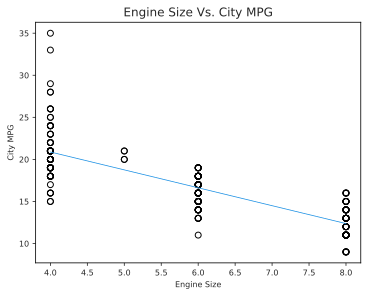

In [5]:
m, b = np.polyfit(mpg.cyl, mpg.cty, 1)
plt.plot(mpg.cyl, mpg.cty, 'o', fillstyle='none')
plt.plot(mpg.cyl, m * mpg.cyl + b)
plt.title('Engine Size Vs. City MPG')
plt.xlabel('Engine Size')
plt.ylabel('City MPG');

As expected, there is a negative relationship between engine size and city MPG. Let’s build a simple linear model to see if engine type affects mpg. In mathematical notation, this model would look like:

$$
\begin{aligned}
mpg_i &\sim \text{Normal}(\mu_i, \sigma)\\
\mu_i &= \alpha + \beta \times \text{Engine}_i \\
\alpha &\sim \text{Normal}(0, 100)\\
\beta &\sim \text{Normal}(0, 100)\\
\sigma &\sim \text{Unifrom}(0, 100)\\
\end{aligned}
$$


#### Prior Simulation

Notice that I am specifying pretty uninformative priors. To see just how uninformative, let’s do some simulations. Centering continuous variables can also help to interpret priors.

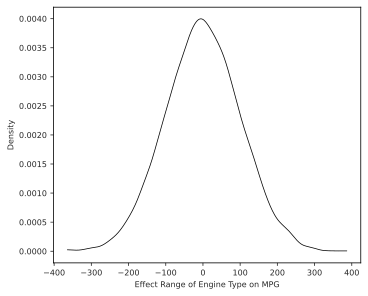

In [6]:
# draw from a normal distribution
sim_data = np.random.normal(0, 100, 10_000)

az.plot_kde(sim_data)
plt.xlabel('Effect Range of Engine Type on MPG')
plt.ylabel('Density');

So, we are telling the model that the average effect of engine type on MPG will be zero, but can range between a decrease of 200 and an increase of 200 MPG with reasonably high probability. Thus, this is a pretty flat prior. Cars with bigger engines will probably get lower MPG, but they probably don’t get 200 MPG lower! This is a good time to point out that uninformative priors are rarely ever a good idea since we almost always know something about the effects we are interested in before we estimate them.

Finally, let’s examine the prior for $\sigma$.

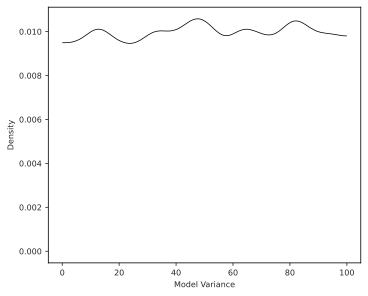

In [7]:
sim_data = np.random.uniform(0, 100, 10_000)

az.plot_kde(sim_data)
plt.xlabel('Model Variance')
plt.ylabel('Density');

#### Model Programming

Now that we know what we are telling the model a priori, let’s program the model.

##### Vectorized Syntax

In [8]:
mpg_model_1 = '''
data {              
    int N;                      // Number of observations (rows of data)
    vector[N] mpg;              // Variable called mpg as a vector of length N
    vector[N] engine;           // Variable called engine as a vector of length N
}
parameters {        
  real alpha;                   // This will be our intercept
  real beta;                    // This will be our slope
  real sigma;                   // This will be our variance parameter
}
model {
  vector[N] mu;                 // Create the linear predictor mu
  mu = alpha + beta * engine;   // Write the linear combination

  // Priors
  alpha ~ normal(0, 100);
  beta ~ normal(0, 100);
  sigma ~ uniform(0, 100);

  // Likelihood function
  mpg ~ normal(mu, sigma);
}

generated quantities {
    vector[N] log_lik;          // Calculate Log-Likelihood
    vector[N] y_rep;            // Replications from posterior predictive distribution
    
    for (i in 1:N) {
        // generate mpg predicted value
        real mpg_hat = alpha + beta * engine[i];
        
        // calculate log-likelihood
        log_lik[i] = normal_lpdf(mpg[i] | mpg_hat, sigma);
        // normal_lpdf is the log of the normal probability density function
        
        // generate replication values
        y_rep[i] = normal_rng(mpg_hat, sigma);
        // normal_rng generates random numbers from a normal distribution
        
    }
}
'''

In [9]:
stan_file = './stan_models/mpg_model_1'
if not os.path.isfile(stan_file):
    with open(stan_file+".stan", 'w') as f:
        print(mpg_model_1, file=f)
    stan_model = CmdStanModel(stan_file=stan_file+".stan", cpp_options={'STAN_THREADS':'true', 'parallel_chains': 4})
else:
    stan_model = CmdStanModel(exe_file=stan_file)

##### Target+ Syntax

Stan allows users to directly specify the log-posterior using target+ syntax. Using this syntax, `y ~ normal(mu, sigma)`; becomes `target += normal_lpdf(y | mu, sigma)`. This directly updates the target log density.

In [10]:
mpg_model_1a = '''
data {              
    int N;                      // Number of observations (rows of data)
    vector[N] mpg;              // Variable called mpg as a vector of length n
    vector[N] engine;            // Variable called weight as a vector of length n
}
parameters {        
  real alpha;                   // This will be our intercept
  real beta;                    // This will be our slope
  real sigma;                   // This will be our variance parameter
}
model {
  vector[N] mu;                 // Create the linear predictor mu
  mu = alpha + beta * engine;   // Write the linear combination

  // Priors
  target += normal_lpdf(alpha | 0, 100);
  target += normal_lpdf(beta | 0, 100);
  target += uniform_lpdf(sigma | 0, 100);

  // Likelihood function
  target += normal_lpdf(mpg | mu, sigma);
}

generated quantities {
    vector[N] log_lik;          // Calculate Log-Likelihood
    vector[N] y_rep;            // Replications from posterior predictive distribution
    
    for (i in 1:N) {
        // generate mpg predicted value
        real mpg_hat = alpha + beta * engine[i];
        
        // calculate log-likelihood
        log_lik[i] = normal_lpdf(mpg[i] | mpg_hat, sigma);
        // normal_lpdf is the log of the normal probability density function
        
        // generate replication values
        y_rep[i] = normal_rng(mpg_hat, sigma);
        // normal_rng generates random numbers from a normal distribution
        
    }
}
'''

In [11]:
stan_file = './stan_models/mpg_model_1a'
if not os.path.isfile(stan_file):
    with open(stan_file+".stan", 'w') as f:
        print(mpg_model_1a, file=f)
    stan_model = CmdStanModel(stan_file=stan_file+".stan", cpp_options={'STAN_THREADS':'true', 'parallel_chains': 4})
else:
    stan_model = CmdStanModel(exe_file=stan_file)

Now, let’s get into running some linear models.

### Linear Models in Stan

#### Import Data

We’ll use the Motor Trend Car Road Tests `mtcars` data as our practice data set.

Let’s walk though what our variables are:

- `mpg`: Miles pre gallon
- `cyl`: Number of cylinders
- `disp` Displacement (cu. in.)
- `hp`: Gross horsepower
- `drat`: Rear axle ratio
- `wt`: Weight (1000 lbs)
- `qsec`: 1/4 mile time
- `vs`: Engine (0 = V-shaped, 1 = straight)
- `am`: Transmission (0 = automatic, 1 = manual)
- `gear`: Number of forward gears
- `carb`: Number of carburetors

In [12]:
mtcars = pd.read_csv('../../data/mtcars.csv', sep=',', header=0)
mtcars.head()

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


For our research question, we will be investigating how different characteristics of a car affect it’s MPG. To start with, we will test how vehicle weight affects MPG. Let’s do some preliminary analysis of this question with visualizations.

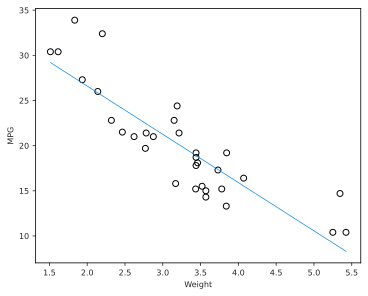

In [13]:
m, b = np.polyfit(mtcars.wt, mtcars.mpg, 1)
plt.plot(mtcars.wt, mtcars.mpg, 'o', fillstyle='none')
plt.plot(mtcars.wt, m * mtcars.wt + b)
plt.xlabel('Weight')
plt.ylabel('MPG');

As expected, there seems to be a negative relationship between these variables. Let’s add in a fitted line:

#### Build a Model - Models with a Single Predictor

Now we will build a model in Stan to formally estimate this relationship. 

Here is the model that we want to estimate in Stan:
$$
\begin{aligned}
mpg_i &\sim \text{Normal}(\mu_, \sigma)\\
\mu_i &= \alpha + \beta \times \text{Weight} \\
\end{aligned}
$$

Now, program the model:

In [14]:
mtcar_model_1 = '''
data {              
    int N;                      // Number of observations (rows of data)
    vector[N] mpg;              // Variable called mpg as a vector of length N
    vector[N] weight;           // Variable called weight as a vector of length N
}
parameters {        
  real alpha;                   // This will be our intercept
  real beta_w;                  // This will be our slope
  real<lower=0> sigma;          // This will be our variance parameter
                                // variance parameter and restrict it to positive values
}
model {
  vector[N] mu;                 // Create the linear predictor mu
  mu = alpha + beta_w * weight;   // Write the linear combination

  // Likelihood function
  mpg ~ normal(mu, sigma);
}
'''

In [15]:
stan_file = './stan_models/mtcar_model_1'
if not os.path.isfile(stan_file):
    with open(stan_file+".stan", 'w') as f:
        print(mtcar_model_1, file=f)
    stan_model = CmdStanModel(stan_file=stan_file+".stan", cpp_options={'STAN_THREADS':'true', 'parallel_chains': 4})
else:
    stan_model = CmdStanModel(exe_file=stan_file)

Once we finish writing the model, we need to run the code block to compile it into C++ code. This will also us to sample from the model and obtain the parameter estimates. Let’s do that now.

The next step is to prepare the data for Stan. Stan can’t use the same types of data that python can. For example, Stan requires dictionary, not data frames, and it cannot accept factors. 

In [16]:
model_data = {
    'mpg': mtcars.mpg,
    'weight': mtcars.wt,
    'N': len(mtcars.mpg)
}

linear_fit_1 = stan_model.sample(data=model_data, show_progress=False)

02:18:51 - cmdstanpy - INFO - CmdStan start processing
02:18:51 - cmdstanpy - INFO - CmdStan start processing
02:18:51 - cmdstanpy - INFO - CmdStan done processing


In [17]:
# summarize our model
linear_fit_1.summary(percentiles=(5, 95)).round(2)

,Mean,MCSE,StdDev,MAD,5%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-51.05,0.03,1.24,1.02,-53.51,-49.69,1349.17,1914.99,1.00
alpha,37.25,0.05,2.00,1.96,34.03,40.64,1400.48,1428.31,1.00
beta_w,-5.33,0.02,0.60,0.58,-6.28,-4.35,1415.35,1348.64,1.01
sigma,3.18,0.01,0.41,0.40,2.58,3.90,1709.18,1823.06,1.00


Let’s run through the interpretation of this model:
- `alpha` For a car with a weight of zero, the expected MPG is 37.38. Obviously, a weight of zero is impossible, so we’ll want to address this in our next model.
- `beta_w` Comparing two cars who differ by 1000 pounds, the model predicts a difference of 5.38 miles per gallon.
- `sigma` The model predicts MPG within 3.17 points.
- `lp__` Logarithm of the (unnormalized) posterior density. This log density can be used in various ways for model evaluation and comparison.

Ok, now that we’ve written our model, let’s make a few improvements. First, let’s center our weight variable so that we can get a more meaningful interpretation of the intercept parameter alpha. We can accomplish this by subtracting the mean from each observation. This will change the interpretation of the intercept to be the average MPG when weight is held constant at it’s average value.

In [18]:
mtcars['wt_c'] = mtcars.wt - mtcars.wt.mean()

Now that we changed the name of the variable name, we also need to change our model code to incorporate this change. While we are adjusting the code, we’ll also restrict the scale parameter to be positive. This will help our model be a bit more efficient.

In [19]:
mtcar_model_2 = '''
data {              
    int N;                      // Number of observations (rows of data)
    vector[N] mpg;              // Variable called mpg as a vector of length N
    vector[N] weight_c;         // Variable called weight as a vector of length N
}
parameters {        
  real alpha;                   // This will be our intercept
  real beta_w;                  // This will be our slope
  real<lower=0> sigma;          // This will be our variance parameter
                                // variance parameter and restrict it to positive values
}
model {
  vector[N] mu;                 // Create the linear predictor mu
  mu = alpha + beta_w * weight_c;   // Write the linear combination

  // Likelihood function
  mpg ~ normal(mu, sigma);
}
'''

stan_file = './stan_models/mtcar_model_2'
if not os.path.isfile(stan_file):
    with open(stan_file+".stan", 'w') as f:
        print(mtcar_model_2, file=f)
    stan_model = CmdStanModel(stan_file=stan_file, cpp_options={'STAN_THREADS':'true', 'parallel_chains': 4})
else:
    stan_model = CmdStanModel(exe_file=stan_file)

In [20]:
model_data = {
    'mpg': mtcars.mpg,
    'weight_c': mtcars.wt_c,
    'N': len(mtcars.mpg)
}

linear_fit_2 = stan_model.sample(data=model_data, show_progress=False)

02:18:51 - cmdstanpy - INFO - CmdStan start processing
02:18:51 - cmdstanpy - INFO - CmdStan start processing
02:18:51 - cmdstanpy - INFO - CmdStan done processing


In [21]:
# summarize our model
linear_fit_2.summary(percentiles=(5, 95)).round(2)

,Mean,MCSE,StdDev,MAD,5%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-51.07,0.03,1.28,1.03,-53.59,-49.69,1794.67,2460.56,1.0
alpha,20.09,0.01,0.56,0.56,19.17,21.02,3526.25,3097.77,1.0
beta_w,-5.35,0.01,0.58,0.55,-6.27,-4.40,3272.02,2324.10,1.0
sigma,3.18,0.01,0.44,0.42,2.56,3.97,3091.86,2739.71,1.0


Let’s interpret this model:
- `alpha` When a vehicle’s weight is held at its average value, the expected MPG is 20.09.
- `beta_w` This estimate has the same interpretation as before.
- `sigma` This estimate has the same interpretation as before.
- `lp__` This estimate has a relatively similar value (in absolute value) than it did in the previous model indicating that it performed more or less the same.

#### Build a Model - Models with Multiple Predictors

To add more predictors, we just need to adjust out model code. Let’s add in the vehicle’s cylinders and horsepower. We’ll also center these variables.

In [22]:
mtcar_model_3 = '''
data {              
    int N;                        // Number of observations (rows of data)
    vector[N] mpg;                // vector of length n for the car's MPG
    vector[N] weight_c;           // vector of length n for the car's weight
    vector[N] cylinders_c;        // vector of length n for the car's cylinders
    vector[N] hp_c;               // vector of length n for the car's horsepower
}
parameters {        
    real alpha;                   // Intercept parameter
    real beta_w;                  // Weight slope parameter
    real beta_c;                  // Cylinder slope parameter
    real beta_h;                  // Horsepower slope parameter
    real<lower=0> sigma;          // variance parameter and restrict it to positive values
}
model {
  vector[N] mu;                    // Linear predictor mu
  
  // Linear equation
  mu = alpha + beta_w * weight_c + beta_c * cylinders_c + beta_h * hp_c;

  // Likelihood function
  mpg ~ normal(mu, sigma);
}
'''

stan_file = './stan_models/mtcar_model_3'
if not os.path.isfile(stan_file):
    with open(stan_file+".stan", 'w') as f:
        print(mtcar_model_3, file=f)
    stan_model = CmdStanModel(stan_file=stan_file+".stan", cpp_options={'STAN_THREADS':'true', 'parallel_chains': 4})
else:
    stan_model = CmdStanModel(exe_file=stan_file)

In [23]:
mtcars['cyl_c'] = mtcars.cyl - mtcars.cyl.mean()
mtcars['hp_c'] = mtcars.hp - mtcars.hp.mean()

model_data = {
    'mpg': mtcars.mpg,
    'weight_c': mtcars.wt_c,
    'cylinders_c': mtcars.cyl_c,
    'hp_c': mtcars.hp_c,
    'N': len(mtcars.mpg)
}

linear_fit_3 = stan_model.sample(data=model_data, show_progress=False)

02:18:51 - cmdstanpy - INFO - CmdStan start processing
02:18:51 - cmdstanpy - INFO - CmdStan start processing
02:18:51 - cmdstanpy - INFO - CmdStan done processing


In [24]:
# summarize our model
linear_fit_3.summary(percentiles=(5, 95)).round(2)

,Mean,MCSE,StdDev,MAD,5%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-45.15,0.04,1.69,1.46,-48.49,-43.11,1675.95,2113.43,1.0
alpha,20.08,0.01,0.47,0.44,19.31,20.86,3647.75,2219.66,1.0
beta_w,-3.15,0.01,0.78,0.77,-4.43,-1.87,3386.44,2545.75,1.0
beta_c,-0.95,0.01,0.58,0.56,-1.91,-0.02,2428.00,2228.52,1.0
beta_h,-0.02,0.00,0.01,0.01,-0.04,0.00,3072.13,2539.32,1.0
sigma,2.63,0.01,0.37,0.35,2.09,3.28,3035.57,2389.32,1.0


After adjusting for a car’s cylinders and horsepower two cars that differ by 1000 pounds, the model predicts a difference of 3.18 miles per gallon. Notice that `lp__` is now even lower, suggesting that this latest model is a better fit.

### Assessing Our Model

In [25]:
print(linear_fit_3.diagnose())

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



#### Model Convergence

Now that we’ve built a decent model, we need to see how well it actual preforms. First, we’ll want to check that our chains have converged and are producing reliable point estimates. We can do this with a traceplot.

In [26]:
# Convert CmdStanPy (CmdStanMCMC object) data into an InferenceData object 
az_linear_fit_3 = az.from_cmdstanpy(linear_fit_3)
az_linear_fit_3

Inference data with groups:
	> posterior
	> sample_stats

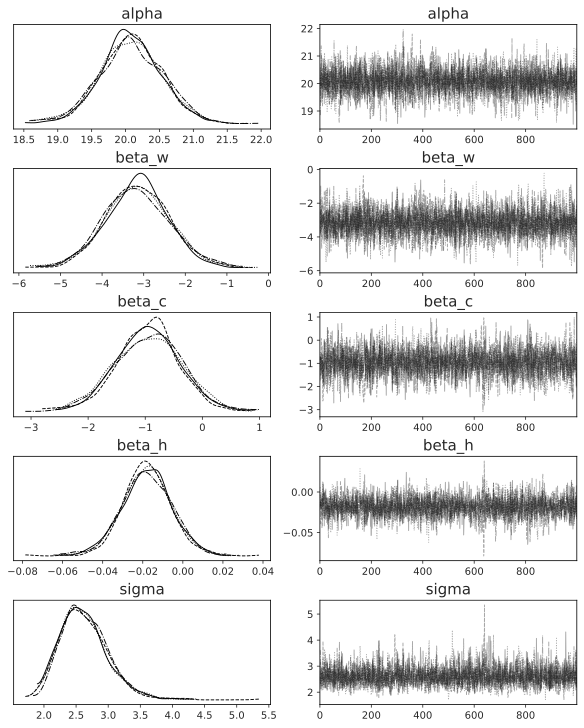

In [27]:
# extract the posterior draws and plot trace
_, ax = plt.subplots(5, 2, figsize=(8,10))
az.plot_trace(az_linear_fit_3, axes=ax);

The fuzzy caterpillar appearance indicates that the chains are mixing well and have converged to a common distribution. We can also assess the R-hat values for each parameter in the summary produces earlier. As a rule of thumb, R-hat values less than 1.05 indicate good convergence.

#### Effective Sample Size

The effective sample size estimates the number of independent draws from the posterior distribution of a given estimate. This metric is important because Markov chains can have autocorrelation which will lead to biased parameter estimates.

Try to visualize the ratio of the effective sample size to the total number of samples - the larger the ratio the better. The rule of thumb here is to worry about ratios less than 0.1.

### Posterior Predictive Checks

One of the most powerful tools of Bayesian inference is to conduct posterior predictive checks. This check is designed to see how well our model can generate data that matches observed data. If we built a good model, it should be able to generate new observations that very closely resemble the observed data.

In order to perform posterior predictive checks, we will need to add in some code to our model. Specifically we need to calculate replications of our outcome variable. We can do this using the `generated quantities` section.

In [28]:
mtcar_model_3_ppc = '''
data {
    int N; //number of observations in the data
    vector[N] mpg; //vector of length n for the car's MPG
    vector[N] weight_c; //vector of length n for the car's weight
    vector[N] cylinders_c; ////vector of length n for the car's cylinders
    vector[N] hp_c; //vector of length n for the car's horsepower
}
parameters {
    real alpha; //the intercept parameter
    real beta_w; //slope parameter for weight
    real beta_c; //slope parameter for cylinder
    real beta_h; //slope parameter for horsepower
    real<lower=0> sigma; //variance parameter and restrict it to positive values
}
model {
    //linear predictor mu
    vector[N] mu;

    //write the linear equation
    mu = alpha + beta_w * weight_c + beta_c * cylinders_c + beta_h * hp_c;

    //likelihood function
    mpg ~ normal(mu, sigma);
}
generated quantities {
    //replications for the posterior predictive distribution
    array[N] real y_rep;
    y_rep = normal_rng(alpha + beta_w * weight_c + beta_c * 
    cylinders_c + beta_h * hp_c, sigma);
}
'''

stan_file = './stan_models/mtcar_model_3_ppc'
if not os.path.isfile(stan_file):
    with open(stan_file+".stan", 'w') as f:
        print(mtcar_model_3_ppc, file=f)
    stan_model = CmdStanModel(stan_file=stan_file+".stan", cpp_options={'STAN_THREADS':'true', 'parallel_chains': 4})
else:
    stan_model = CmdStanModel(exe_file=stan_file)

In the code block above, `normal_rng` is the Stan function to generate observations from a normal distribution. So, `y_rep` generates new data points from a normal distribution using the linear model we built `mu` and a variance `sigma`. Now let’s re-estimate the model:

In [29]:
# sample the model
linear_fit_3_ppc = stan_model.sample(data=model_data, show_progress=False)

02:18:52 - cmdstanpy - INFO - CmdStan start processing
02:18:52 - cmdstanpy - INFO - CmdStan start processing
02:18:52 - cmdstanpy - INFO - CmdStan done processing


In [30]:
# summarize the model
summary = linear_fit_3_ppc.summary(percentiles=(5, 95)).round(2)
summary[~summary.index.str.contains('y_rep')]

,Mean,MCSE,StdDev,MAD,5%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-45.16,0.04,1.65,1.50,-48.37,-43.10,1478.64,2048.30,1.0
alpha,20.10,0.01,0.46,0.46,19.34,20.86,3974.09,2220.33,1.0
beta_w,-3.16,0.01,0.79,0.79,-4.45,-1.88,3581.41,2514.25,1.0
beta_c,-0.94,0.01,0.58,0.56,-1.88,0.01,2743.98,1912.50,1.0
beta_h,-0.02,0.00,0.01,0.01,-0.04,0.00,3021.84,2264.23,1.0
sigma,2.63,0.01,0.37,0.36,2.08,3.30,3210.18,2594.10,1.0


In our model output, we now have a replicated y value for every row of data. We can use these values to plot the replicated data against the observed data.

In [31]:
# Convert CmdStanPy (CmdStanMCMC object) data into an InferenceData object 
az_linear_fit_3 = az.from_cmdstanpy(linear_fit_3_ppc, posterior_predictive=['y_rep'], observed_data={'mpg': mtcars.mpg}, dtypes={"y_rep": float})
az_linear_fit_3

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

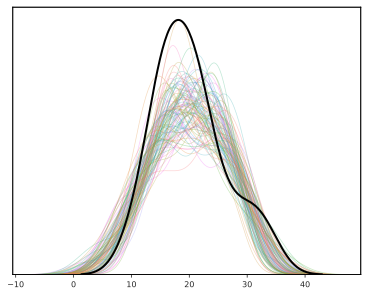

In [ ]:
_, axes = plt.subplots()
sns.kdeplot(az_linear_fit_3.posterior_predictive.y_rep.to_numpy()[3, :100,:].T, legend=False, ax=axes, alpha=0.3)
ax2 = axes.twinx()
sns.kdeplot(mtcars.mpg, legend=False, ax=ax2, color='k', linewidth=2)
axes.get_yaxis().set_visible(False)
ax2.get_yaxis().set_visible(False);

The closer the replicated values (`yrep`) get to the observed values (`y`) the more accurate the model. Here it looks like we could probably do a bit better, though the lose fit is likely due to the small sample size (which adds more uncertainty).

### Improving the Model with Better Priors

To improve this model, let’s use more informative priors. Priors allow us to incorporate our background knowledge on the question into the model to produce more realistic estimates. For our question here, we probably don’t expect the weight of a vehicle to change its MPG more that a dozen or so miles per gallon. Unfortunately, because we didn’t specify priors in the previous models, it defaulted to using flat priors which essentially place an equal probably on all possible coefficient values - not very realistic. Let’s fix that.

To get a better sense of what priors to use, it’s a good idea to use prior predictive checks, which are a lot like posterior predictive checks only they don’t include any data. The goal is to select priors that put some probably over all plausible vales.